# Import libraries

In [199]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import emcee
import corner
import tqdm

# Define constants

In [157]:
c = 299792.458 #is this in the correct units?
#H0 = 75 # might be able to find this myself?
f0 = 6.61* 10**-9 * 10**(-7) * (3.2408*10**(-25))**(-2)
megaparsec = 3.0856775814913673 * 10**10

# Some key functions

In [193]:
#order of variables: z, k, H0, omega_M, omega_DE, LPeakLambda, rc

def scale_factor(z):
    return 1/(1+z)

def curvature(omega_k, H0):
    k = -(H0**2)*omega_k/(c**2)
    return k

def curv_scale(H0, omega_M, omega_DE):
    R0 = c/(H0*np.sqrt(np.abs(omega_M+omega_DE-1)))
    return R0

def Friedmann_eq(z, omega_k, H0, omega_M, omega_DE):
    a = scale_factor(z)
    H2 = (H0**2)*(omega_M/(a**3) + omega_DE + omega_k/(a**2))
    return np.sqrt(H2)

def integrand(z, omega_k, H0, omega_M, omega_DE):
    return c/Friedmann_eq(z, omega_k, H0, omega_M, omega_DE)

def co_moving_dist(z_up, omega_k, H0, omega_M, omega_DE):
    #print(f"z_up: {z_up}")
    #print(f"k: {k}")
    dist_c = []
    for zval in z_up:
        dist, err = scp.integrate.quad(integrand, 0, zval, args = (omega_k, H0, omega_M, omega_DE))
    dist_c.append(dist)
    return np.array(dist_c)

def Sk(omega_k, H0, omega_M, omega_DE, rc):
    k = curvature(omega_k, H0)
    R0 = curv_scale(H0, omega_M, omega_DE)
    if k == 0:
        sk = rc
    elif k > 0:
        sk = R0*np.sin(rc/R0)
    elif k < 0:
        sk = R0*np.sinh(rc/R0)
    return sk

def mag_model(z, omega_k, H0, omega_M, omega_DE, LPeakLambda):
    rc = co_moving_dist(z, omega_k, H0, omega_M, omega_DE)
    sk = Sk(omega_k, H0, omega_M, omega_DE, rc)
    flux = LPeakLambda*(10**32)/(4*np.pi*(sk**2)*((1+z)**2))
    argument = flux/f0
    mag = -2.5*np.log10(argument)
    return mag

# Load the data

In [159]:
sn_z, sn_mag, sn_mag_err = np.loadtxt("sn_data.txt", usecols=(1,2,3), unpack = True)

## Priors

Parameters of model are: {k, H0, omega_M, omega_DE, LPeakLambda}

Priors are: {k=0, H0~70, etc}

Should priors be uniform or Gaussian over the range? - use uniform unless I have good reasons to use a Gaussian (eg if I use the Planck result as a prior, the prior could be a Gaussian with st dev being the error given by Planck)

In [170]:
def log_prior(theta):
    #print("prior func run")
    k, H0, omega_M, omega_DE, LPeakLambda = theta
    if -1<k<1 and 60<H0<80 and 0<omega_M<2 and 0<omega_DE<2 and (1)<LPeakLambda<(10): #go back to previous sensible priors
        return 0.0
    return -np.inf

priors_central = [0, 70, 1, 1, 5]
    

# Likelihood function

In [171]:
def log_likelihood(theta, z, mag, magerr):
    #print("log likelihood run")
    k, H0, omega_M, omega_DE, LPeakLambda = theta
    model = mag_model(z, k, H0, omega_M, omega_DE, LPeakLambda)
    return -0.5*np.sum((mag - model)**2 / magerr**2 + np.log(magerr**2))


def log_probability(theta, z, mag, magerr):
    #print("log prob run")
    lp = log_prior(theta)
    if not np.isfinite(lp):
        #print(-np.inf)
        return -np.inf
    #print(lp + log_likelihood(theta, z, mag, magerr))
    return lp + log_likelihood(theta, z, mag, magerr)


# The MCMC algorithm

Questions to investigate: how many chains should I discard? What is burn in? How many walkers do I need? How many steps should the walkers take?

In [198]:
pos = priors_central + np.random.randn(10, 5)
print(pos)
nsteps = 500 #number of steps walkers take
ndiscard = 10 #how many steps at the beginning of the chain to discard
nwalkers, ndim = pos.shape
print(pos.shape)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args = (sn_z, sn_mag, sn_mag_err)
)
print(sampler)
sampler.run_mcmc(pos, nsteps, progress = True)
flat_samples = sampler.get_chain(discard = ndiscard, thin = 15, flat = True)


[[ 0.30414079 49.67993496  2.39553385 -0.13744194  6.11580905]
 [-1.08785749 51.72542259  0.18550387  1.78238617  5.69129451]
 [ 0.67738077 50.50181844  0.75778313 -0.19196572  3.9696514 ]
 [ 0.18261184 49.00313852  2.67418796  2.14634251  3.16595864]
 [ 1.84007394 49.41944282  2.11326785  1.01496269  5.95254561]
 [-0.47011013 49.93236405  1.40281821  1.56484018  5.4465092 ]
 [ 1.21409511 50.3467413   2.85927646  0.57588256  4.95266676]
 [-0.92618135 49.03466208 -0.2611268   1.82009373  5.57770783]
 [ 0.64553017 50.64091678 -0.05843895  1.06601914  5.72605722]
 [-0.30014789 49.5780664  -0.93981543  1.46889582  2.50193426]]
(10, 5)
log prob run
prior func run
log likelihood run
-424207.0797851361
log likelihood run
log prob run
prior func run
log likelihood run
-508205.85898146336
log likelihood run
log prob run
prior func run
log likelihood run
-395754.0720804771
log likelihood run
log prob run
prior func run
log likelihood run
-439538.3966515028
log likelihood run
log prob run
prior f

C:\Users\milan\AppData\Local\Temp\ipykernel_15568\3760717699.py:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  dist, err = scp.integrate.quad(integrand, 0, zval, args = (k, H0, omega_M, omega_DE))
C:\Users\milan\AppData\Local\Temp\ipykernel_15568\3760717699.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  dist, err = scp.integrate.quad(integrand, 0, zval, args = (k, H0, omega_M, omega_DE))


-45071.779916267675
log likelihood run
log prob run
prior func run
log likelihood run
-213072.59375143045
log likelihood run
log prob run
prior func run
log likelihood run
-75711.87795171661
log likelihood run
log prob run
prior func run
log likelihood run
-242572.92334060327
log likelihood run
log prob run
prior func run
log likelihood run
-113857.59217508973
log likelihood run
log prob run
prior func run
log likelihood run
-174988.54836934252
log likelihood run
log prob run
prior func run
log likelihood run
-394127.0989639013
log likelihood run
log prob run
prior func run
log likelihood run
-270227.84575231164
log likelihood run
log prob run
prior func run
log likelihood run
-111223.96978302837
log likelihood run
log prob run
prior func run
log likelihood run
-162084.69401442364
log likelihood run
log prob run
prior func run
log likelihood run
-479640.3997897621
log likelihood run
log prob run
prior func run
log likelihood run
-289837.54385151307
log likelihood run
log prob run
prior

C:\Users\milan\AppData\Local\Temp\ipykernel_15568\3760717699.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  dist, err = scp.integrate.quad(integrand, 0, zval, args = (k, H0, omega_M, omega_DE))


-30523.321877512375
log likelihood run
log prob run
prior func run
log likelihood run
-48757.98468548259
log likelihood run
log prob run
prior func run
log likelihood run
-124556.93169883861
log likelihood run
log prob run
prior func run
log likelihood run
-165235.88856633345
log likelihood run
log prob run
prior func run
log likelihood run
-478231.85588772286
log likelihood run
log prob run
prior func run
log likelihood run
-80250.08205983955
log likelihood run
log prob run
prior func run
log likelihood run
-138985.35618223078
log likelihood run
log prob run
prior func run
log likelihood run
-148098.20291744574
log likelihood run
log prob run
prior func run
log likelihood run
-158916.5055923364
log likelihood run
log prob run
prior func run
log likelihood run
-163070.03574154095
log likelihood run
log prob run
prior func run
log likelihood run
-62677.16451782944
log likelihood run
log prob run
prior func run
log likelihood run
-147415.81813893205
log likelihood run
log prob run
prior 

C:\Users\milan\AppData\Local\Temp\ipykernel_15568\3760717699.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return c/Friedmann_eq(z, k, H0, omega_M, omega_DE)


-31363.339841249363
log likelihood run
log prob run
prior func run
log likelihood run
-234627.55819923803
log likelihood run
log prob run
prior func run
log likelihood run
-159410.84195837294
log likelihood run
log prob run
prior func run
-inf
log prob run
prior func run
log likelihood run
-238001.0974027422
log likelihood run
log prob run
prior func run
log likelihood run
-141877.11619268014
log likelihood run
log prob run
prior func run
log likelihood run
-26953.928746964597
log likelihood run
log prob run
prior func run
log likelihood run
-11100.975835946425
log likelihood run
log prob run
prior func run
log likelihood run
-200581.4821215457
log likelihood run
log prob run
prior func run
log likelihood run
-15379.109585520078
log likelihood run
log prob run
prior func run
log likelihood run
-217866.3645468447
log likelihood run
log prob run
prior func run
log likelihood run
-285221.1975240628
log likelihood run
log prob run
prior func run
log likelihood run
-532763.1152714777
log li

C:\Users\milan\AppData\Local\Temp\ipykernel_15568\3760717699.py:26: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  dist, err = scp.integrate.quad(integrand, 0, zval, args = (k, H0, omega_M, omega_DE))


log prob run
prior func run
log likelihood run
-87549.63801253971
log likelihood run
log prob run
prior func run
log likelihood run
-159056.5152755597
log likelihood run
log prob run
prior func run
log likelihood run
-343500.00743317977
log likelihood run
log prob run
prior func run
log likelihood run
-14121.60928592783
log likelihood run
log prob run
prior func run
log likelihood run
-92030.93869245602
log likelihood run
log prob run
prior func run
log likelihood run
-354810.6386503197
log likelihood run
log prob run
prior func run
log likelihood run
-32253.71347370811
log likelihood run
log prob run
prior func run
log likelihood run
-11668.929627215757
log likelihood run
log prob run
prior func run
-inf
log prob run
prior func run
log likelihood run
-70565.80303562118
log likelihood run
log prob run
prior func run
-inf
log prob run
prior func run
log likelihood run
-28414.89516730891
log likelihood run
log prob run
prior func run
log likelihood run
-77200.8353784868
log likelihood ru

Traceback (most recent call last):
  File "C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\milan\AppData\Local\Temp\ipykernel_15568\3481193720.py", line 14, in log_probability
    print(lp + log_likelihood(theta, z, mag, magerr))
  File "C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\iostream.py", line 694, in write
    self._schedule_flush()
  File "C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\iostream.py", line 590, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "C:\Users\milan\AppData\Local\Packages\PythonSoftw

KeyboardInterrupt: 

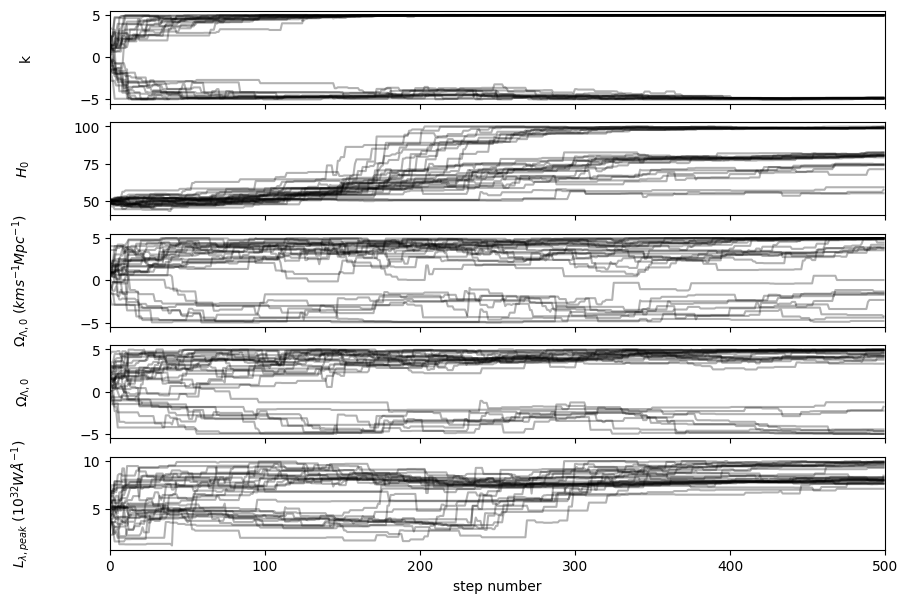

In [183]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["k", "$H_0$", "${Ω_{Λ,0}}$ $({kms^{-1}Mpc^{-1}})$", "${Ω_{Λ,0}}$", "${L_{λ, peak}}$ ${(10^{32} W Å^{-1})}$"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Covariance plots

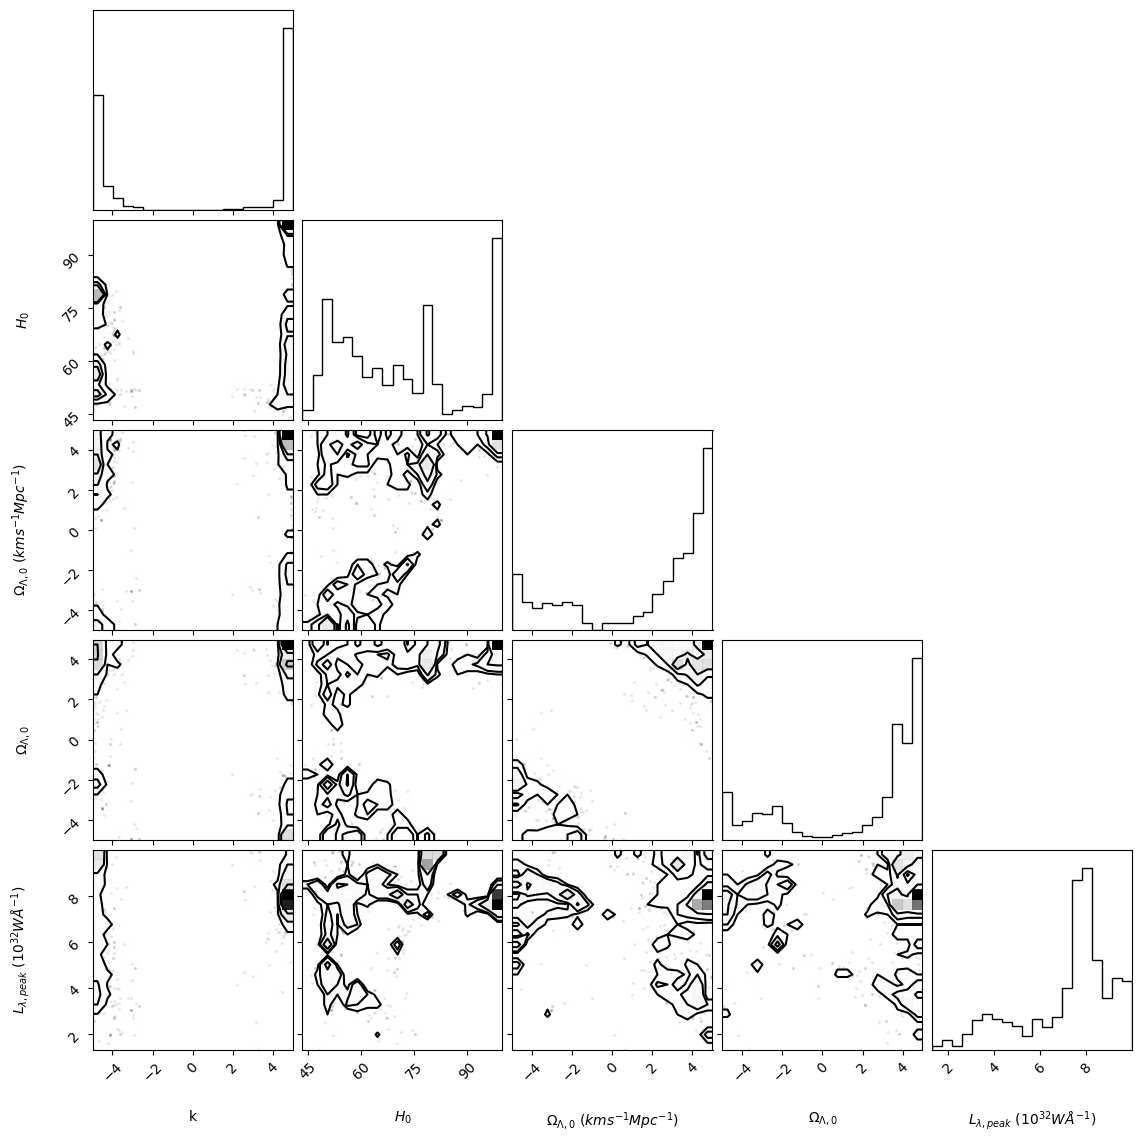

In [185]:

fig = corner.corner(
    flat_samples, labels = labels
)
plt.savefig("corner_plot.png")